In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
msft = yf.Ticker("MSFT")
msft_df = msft.history(start="2010-01-01", end="2025-07-22", interval="1d")
msft_df = msft_df.drop(columns=["Dividends", "Stock Splits"])
msft_df = msft_df[msft_df.index >= "2018-01-01"]
msft_df.to_csv("data/stocks/MSFT.csv")
msft_df.index = msft_df.index.tz_localize(None)

apple = yf.Ticker("AAPL")
apple_df = apple.history(start="2010-01-01", end="2025-07-22", interval="1d")
apple_df = apple_df.drop(columns=["Dividends", "Stock Splits"])
apple_df = apple_df[apple_df.index >= "2018-01-01"]
apple_df.to_csv("data/stocks/AAPL.csv")
apple_df.index = apple_df.index.tz_localize(None)

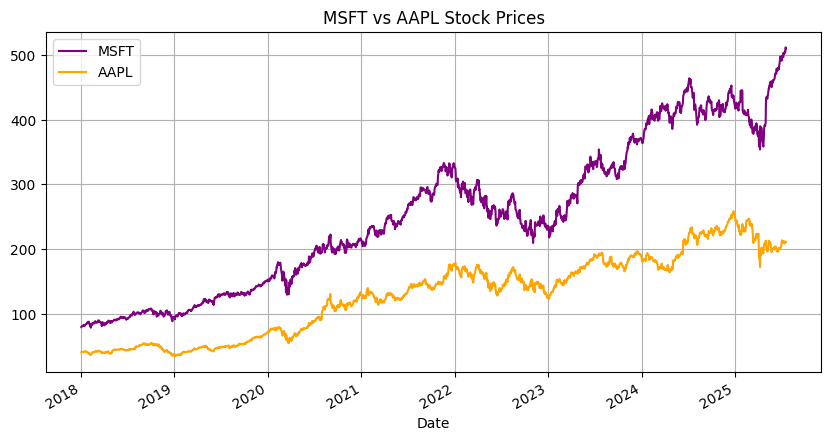

In [3]:
plt.subplots(figsize=(10, 5))
msft_df['Close'].plot(label='MSFT', color='purple')
apple_df['Close'].plot(label='AAPL', color='orange')
plt.title('MSFT vs AAPL Stock Prices')
plt.grid()
plt.legend()

# 1. Split the data for train-test

In [4]:
split_date = '2024-01-02'
train = msft_df.loc[:pd.Timestamp(split_date) - pd.Timedelta(days=1), 'Close']
test  = msft_df.loc[split_date:, 'Close']

In [24]:
model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,5),
                enforce_stationarity=False, enforce_invertibility=False)
res   = model.fit(disp=False)

res.summary()

/Users/diegolarraguibel/Desktop/Proyectos/Financial-Analysis/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/diegolarraguibel/Desktop/Proyectos/Financial-Analysis/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                 1509
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood               -4183.248
Date:                           Sun, 20 Jul 2025   AIC                           8376.496
Time:                                   19:31:54   BIC                           8403.048
Sample:                                        0   HQIC                          8386.389
                                          - 1509                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3414      0.144      2.365      0.018       0.058       0.624
ma.L1         -0.4470      0.139     -3.212      0.001      -0.720      -0.174
ar.S.L5        0.0290      0.021      1.401      0.161      -0.012       0.070
ma.S.L5       -1.0000     49.112     -0.020      0.984     -97.257      95.257
sigma2        15.4365    758.155      0.020      0.984   -1470.520    1501.393
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               486.26
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              11.17   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

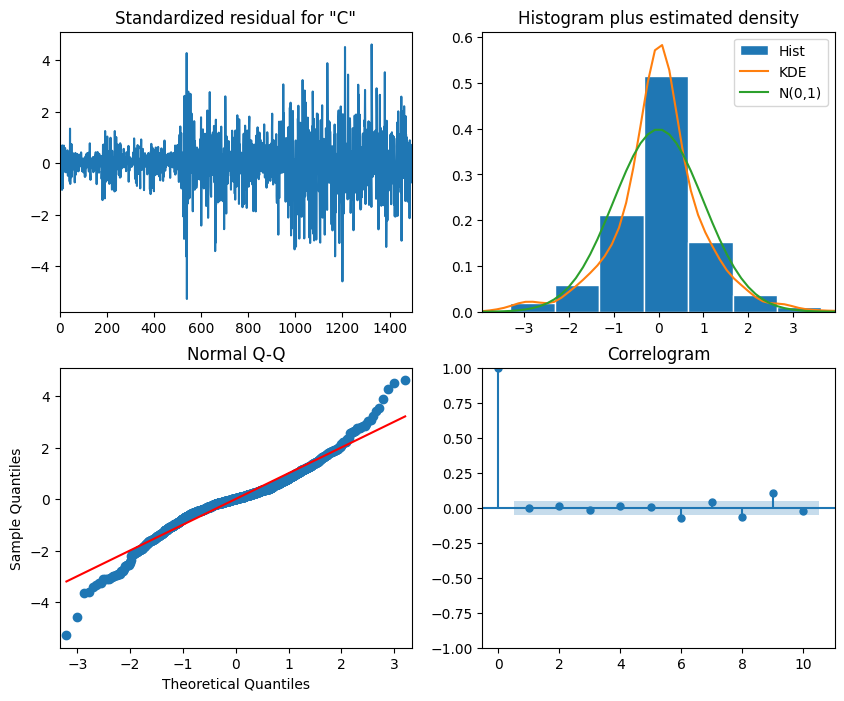

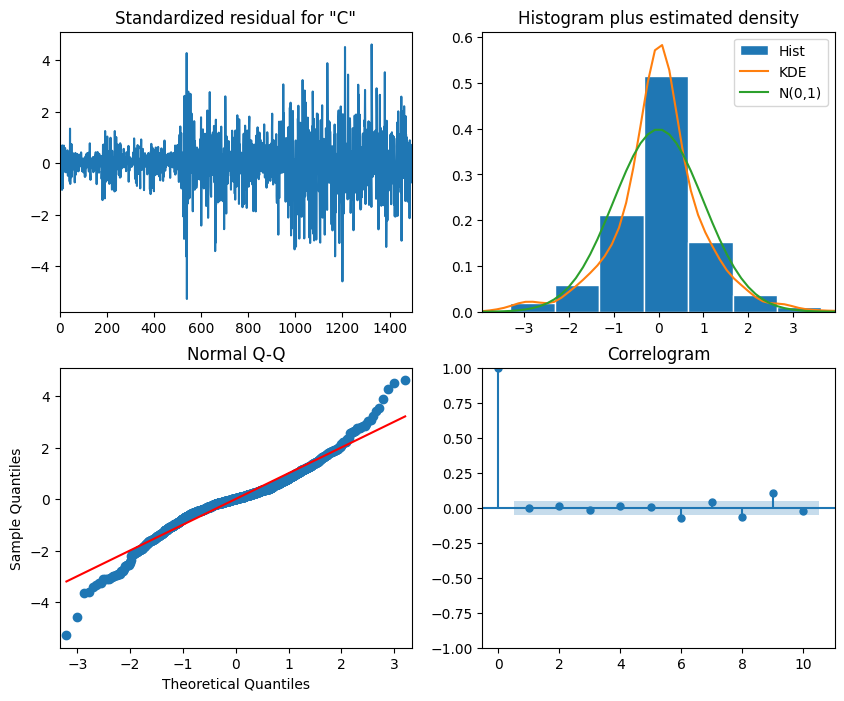

In [21]:
res.plot_diagnostics(figsize=(10, 8))

In [22]:
n_steps = len(test)
forecast_res = res.get_forecast(steps=n_steps)
fc_mean = forecast_res.predicted_mean
fc_ci   = forecast_res.conf_int()

/Users/diegolarraguibel/Desktop/Proyectos/Financial-Analysis/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/diegolarraguibel/Desktop/Proyectos/Financial-Analysis/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


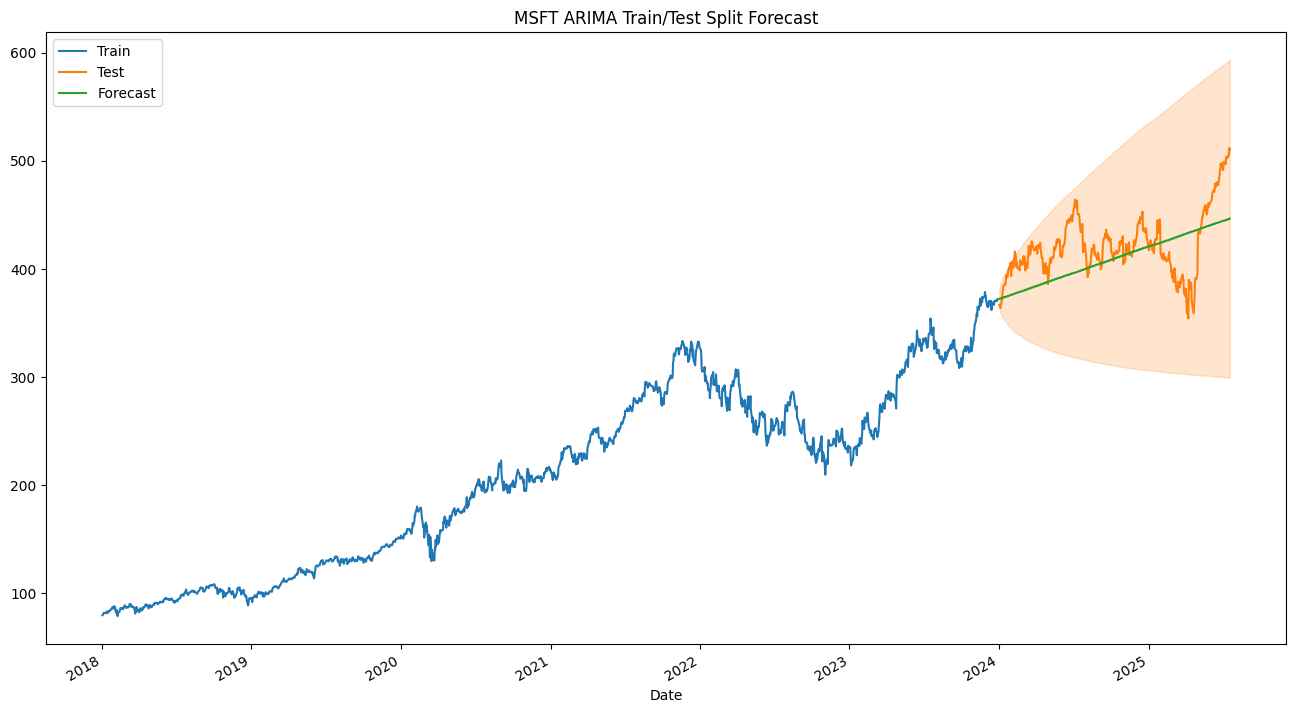

In [23]:
# 4. Plot train, test and forecast
ax = train.plot(label='Train', figsize=(16,9))
test.plot(ax=ax, label='Test', color='C1')
fc_mean.index = test.index 
fc_ci.index   = test.index
fc_mean.plot(ax=ax, label='Forecast', color='C2')
ax.fill_between(test.index, fc_ci.iloc[:,0], fc_ci.iloc[:,1], color='C1', alpha=0.2)
ax.legend()
plt.title("MSFT ARIMA Train/Test Split Forecast")
plt.show()